In [1]:
%matplotlib inline


Classifying Names with a Character-Level RNN

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Приводим к виду словаря {language: [names ...]}
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Spanish.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Czech.txt']
Slusarski


In [6]:
lenth = 0
for key, obj in category_lines.items():
    
    lenth += len(obj)
    
print(lenth)

20074


In [3]:
len(category_lines)

18

In [7]:
os.path.splitext(os.path.basename(filename))

('Czech', '.txt')

In [8]:
print(all_letters)
print(n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
57


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [9]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [10]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter): # Находит индекс, интеджер из нашего списка букав
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter): # Ван-хот для букав, подаем на вход номер
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line): # перевод слова в наш 2-д массив
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        #print(li, letter)
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [11]:
letterToIndex('C')

28

In [12]:
lineToTensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [13]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # 185, 128
        self.i2o = nn.Linear(input_size + hidden_size, output_size) # 185, 16
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # Concatenate *57 + 128* size
        hidden = self.i2h(combined) # make hidden
        output = self.i2o(combined) # make output
        output = self.softmax(output) # softmax
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size) # init hidden

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories) # Вход - 57, 128 хидден, 16 категорий (аутпут)

In [14]:
n_letters

57

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).


Чтобы выполнить шаг этой сети, нам нужно передать вход (в нашем случае, Тензор для текущей буквы) и предыдущее скрытое состояние (которое мы сначала инициализируем как нули). Мы вернем результат (вероятность каждого языка) и следующее скрытое состояние (которое мы придерживаемся для следующего шага).

In [15]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

print(output.shape, next_hidden.shape)

torch.Size([1, 18]) torch.Size([1, 128])


For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.


Для эффективности мы не хотим создавать новый тензор для каждого шага, поэтому мы будем использовать lineToTensor вместо letterToTensor и использовать срезы. Это может быть дополнительно оптимизировано с помощью предварительно вычислительных партий тензоров.

In [16]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9214, -2.8614, -2.8575, -2.9509, -2.8841, -2.8821, -2.8193, -2.9019,
         -2.8821, -2.8784, -2.8859, -2.8024, -2.8789, -2.8532, -2.8840, -2.9882,
         -3.0174, -2.9007]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [17]:
# Вспомогательная функция для интерпретации рез-та

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    print(top_n, top_i)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

tensor([[-2.8024]], grad_fn=<TopkBackward>) tensor([[11]])
('Vietnamese', 11)


We will also want a quick way to get a training example (a name and its
language):




In [18]:
import random

# ретурн рандомный элемент списка
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories) # Выбираем рандом категорию
    line = randomChoice(category_lines[category]) # выбираем рандом фамилию из категории
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) # тензор индекса категории
    line_tensor = lineToTensor(line) # слово в наш ван-хот 2-д массив
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line, category_tensor)

category = Czech / line = Kanak tensor([17])
category = Chinese / line = Che tensor([3])
category = Japanese / line = Mifune tensor([4])
category = Irish / line = Rian tensor([5])
category = German / line = Blumstein tensor([10])
category = Czech / line = Komo tensor([17])
category = Spanish / line = Cruz tensor([6])
category = Russian / line = Kalikhov tensor([7])
category = Polish / line = Zuraw tensor([16])
category = Chinese / line = Sze  tensor([3])


In [19]:
randomChoice(all_categories)

'Scottish'

Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [20]:
# negative log likelihood loss

criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [21]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # Инит скрытое состояние

    rnn.zero_grad() # обнуляем градиенты

    # loop fo every letter, для каждой сохраняем 1 скрытое состояние, которое передаем следующей букве
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    # Делаем лосс, аутпута от ласт буквы
    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    # степ в ручную, лел
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Подсчет времени
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    # берем рандомный пример и трейним на нем
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    # принтим каждые 5к
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    # средний лосс за каждый plot_every добавляем в лист для плота
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 39s) 2.5233 Blanchett / French ✓
10000 10% (1m 18s) 2.1902 Paredes / Dutch ✗ (Portuguese)
15000 15% (1m 56s) 1.9955 Lavoie / French ✓
20000 20% (2m 39s) 2.8425 Kranz / Vietnamese ✗ (German)
25000 25% (3m 13s) 1.7885 Domhnall / Irish ✓
30000 30% (3m 52s) 1.4682 Dieter / German ✓
35000 35% (4m 32s) 3.5368 Mozdzierz / Dutch ✗ (Polish)
40000 40% (5m 15s) 2.8274 Salomon / Russian ✗ (Polish)
45000 45% (5m 55s) 0.5976 Noh / Korean ✓
50000 50% (6m 34s) 0.5561 Shoda / Japanese ✓
55000 55% (7m 13s) 1.1618 Hasminsky / Polish ✗ (Russian)
60000 60% (7m 49s) 2.5579 Huff / Korean ✗ (German)
65000 65% (8m 31s) 0.7333 Yamabe / Japanese ✓
70000 70% (9m 11s) 0.4037 Min / Chinese ✓
75000 75% (9m 49s) 0.4987 Flanagan / Irish ✓
80000 80% (10m 23s) 1.6280 Dunsford / Arabic ✗ (English)
85000 85% (10m 57s) 0.3858 Werner / German ✓
90000 90% (11m 34s) 1.3364 Dan / Vietnamese ✗ (Chinese)
95000 95% (12m 13s) 0.8487 Best / German ✓
100000 100% (12m 49s) 2.4375 Wornhor / Scottish ✗ (German)


In [76]:
len(all_losses)

100

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




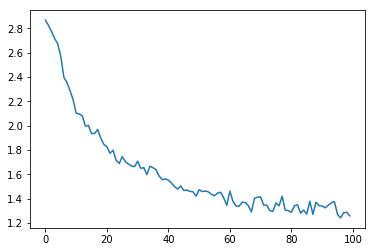

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




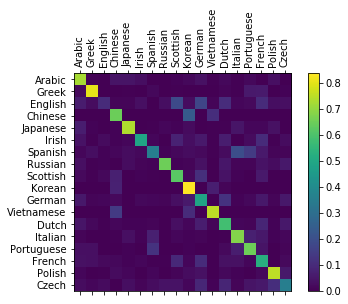

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories) 
n_confusion = 10000

# евал - как шаг треина, но без бекпроп
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample() # берем рандом пример
    output = evaluate(line_tensor) # аутпут от него
    guess, guess_i = categoryFromOutput(output) # категория от аутпута
    category_i = all_categories.index(category) # истинная категория
    confusion[category_i][guess_i] += 1 # инк ячейку

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [77]:
confusion

tensor([[0.7281, 0.0056, 0.0000, 0.0447, 0.0447, 0.0317, 0.0000, 0.0000, 0.0093,
         0.0168, 0.0391, 0.0056, 0.0186, 0.0037, 0.0168, 0.0000, 0.0335, 0.0019],
        [0.0210, 0.8073, 0.0000, 0.0000, 0.0057, 0.0000, 0.0191, 0.0000, 0.0038,
         0.0000, 0.0000, 0.0000, 0.0115, 0.0057, 0.0573, 0.0611, 0.0000, 0.0076],
        [0.0650, 0.0281, 0.1037, 0.0123, 0.0105, 0.0351, 0.0018, 0.0316, 0.1880,
         0.0281, 0.1740, 0.0123, 0.1072, 0.0141, 0.0211, 0.1037, 0.0299, 0.0334],
        [0.0000, 0.0000, 0.0000, 0.6489, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2411, 0.0000, 0.1082, 0.0000, 0.0000, 0.0000, 0.0000, 0.0018, 0.0000],
        [0.0673, 0.0093, 0.0000, 0.0075, 0.7383, 0.0000, 0.0056, 0.0150, 0.0093,
         0.0243, 0.0000, 0.0037, 0.0056, 0.0467, 0.0150, 0.0150, 0.0374, 0.0000],
        [0.0414, 0.0036, 0.0234, 0.0072, 0.0144, 0.4937, 0.0162, 0.0000, 0.0793,
         0.0306, 0.0577, 0.0054, 0.0685, 0.0000, 0.0234, 0.1027, 0.0036, 0.0288],
        [0.0133, 0.031

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [15]:
# функция для вывода
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.47) Russian
(-1.43) Czech
(-3.04) English

> Jackson
(-0.61) Scottish
(-1.83) English
(-1.85) Russian

> Satoshi
(-0.82) Arabic
(-1.45) Japanese
(-1.99) Italian


In [19]:
predict('Huepletov')


> Huepletov
(-0.36) Russian
(-2.33) French
(-3.02) Portuguese


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example: можно пробнуть схожую задачу на датах такогоже типа

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers - затестить, добавив больше слоев
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers - лстм или ГРУ слои
   -  Combine multiple of these RNNs as a higher level network - объеденение нескольких РНН


